In [ ]:
! pip install pandas numpy matplotlib
! pip install opendatasets --upgrade --quiet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python Pillow

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
import opendatasets as od
import os
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import torch
import time

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import torch
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn

In [ ]:
url='https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection'
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


100%|██████████| 15.1M/15.1M [00:01<00:00, 8.82MB/s]

In [ ]:
path='/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
print(os.listdir(path))

['no', 'yes']


In [ ]:
yes='//content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes'
no='/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'

In [ ]:
label={
    'tumor': len(os.listdir(yes)),
    'healthy': len(os.listdir(no))
}
df=pd.DataFrame(list(label.items()), columns=['labels', 'count'])

In [ ]:
df.head()

,labels,count
0,tumor,155
1,healthy,98


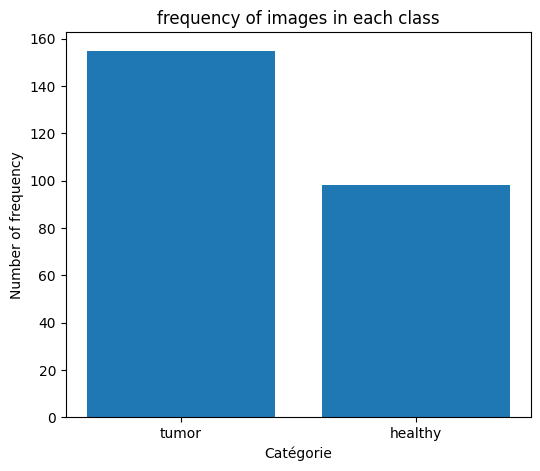

In [ ]:
plt.figure(figsize=(6,5))
plt.bar(df['labels'], df['count'])
plt.title('frequency of images in each class')
plt.xlabel('Catégorie')
plt.ylabel('Number of frequency')
plt.show()

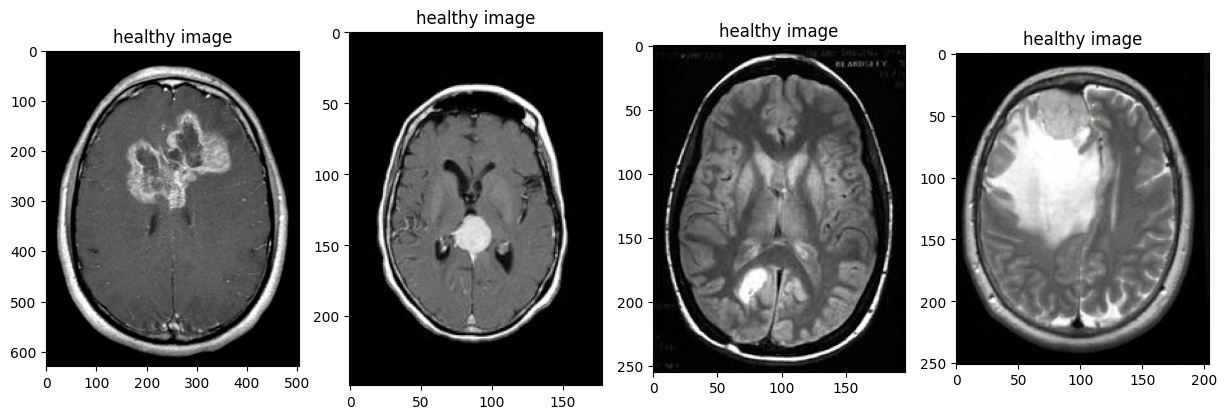

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1,4, i+1)
    img_path = os.path.join(yes, os.listdir(yes)[i])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title('healthy image')

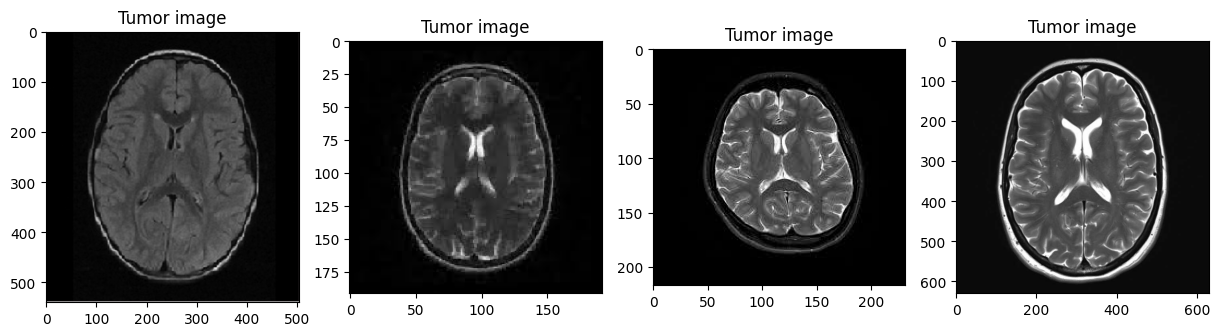

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1,4, i+1)
    img_path = os.path.join(no, os.listdir(no)[i])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title('Tumor image')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def load_dataset_from_directory(directory):
    image_paths = []
    labels = []

    class_names = ['no', 'yes']
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.png', '.jpg', 'JPG', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])

    return image_paths, labels

In [ ]:
image_paths, labels = load_dataset_from_directory(path)
dataset = ImgDataset(image_paths, labels, transform)
print(f"Number of images: {len(image_paths)}")
print(f"Labels: {labels[0]}")
print(f"Labels: {labels[100]}")

Number of images: 253
Labels: 0
Labels: 1


In [ ]:
train_size = int(0.7 * len(dataset))  # %80 Train
val_test_size = len(dataset) - train_size  # %20 Validation-Test
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_size = int(0.6 * len(val_test_dataset)) # Val
test_size = len(val_test_dataset) - val_size # Test
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Load dataset with Dataloader with batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

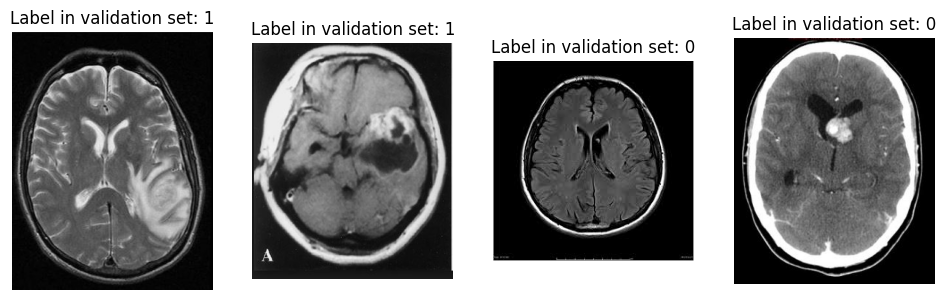

In [ ]:
class_names = [0, 1]
def show_images_with_labels(image_paths, labels, class_names, num_images=5):
    plt.figure(figsize=(15,15))

    for i in range(4):
        # Open image
        img = Image.open(image_paths[i])

        # Plot image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Label in validation set: {class_names[labels[i]]}")
        plt.axis('off')

    plt.show()

# Example usage: Show first 5 images from the validation set
show_images_with_labels(val_images, val_labels, class_names)

In [ ]:
dataset = datasets.ImageFolder(root=path, transform=transform)

class_names = dataset.classes
num_classes = len(class_names)
print(num_classes)

2


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet152_model = models.resnet152(pretrained=True)
resnet152_model.fc = nn.Linear(resnet152_model.fc.in_features, num_classes)
resnet152_model = resnet152_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 176MB/s]


In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0


    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()



    average_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100

    return average_loss, accuracy


In [ ]:
c


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152_model.parameters(), lr=1e-4, weight_decay=1e-3)

Epoch [1/35], Train Loss: 0.0001, Train Accuracy: 100.00%, Validation Loss: 0.5006, Validation Accuracy: 84.44%
Epoch [2/35], Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.4140, Validation Accuracy: 84.44%
Epoch [3/35], Train Loss: 0.0000, Train Accuracy: 100.00%, Validation Loss: 0.4336, Validation Accuracy: 84.44%
Epoch [4/35], Train Loss: 0.0001, Train Accuracy: 100.00%, Validation Loss: 0.5389, Validation Accuracy: 84.44%
Epoch [5/35], Train Loss: 0.0015, Train Accuracy: 100.00%, Validation Loss: 0.8339, Validation Accuracy: 82.22%
Epoch [6/35], Train Loss: 0.0221, Train Accuracy: 99.44%, Validation Loss: 0.6634, Validation Accuracy: 84.44%
Epoch [7/35], Train Loss: 0.0530, Train Accuracy: 98.87%, Validation Loss: 1.1574, Validation Accuracy: 80.00%
Epoch [8/35], Train Loss: 0.0376, Train Accuracy: 99.44%, Validation Loss: 0.5681, Validation Accuracy: 82.22%
Epoch [9/35], Train Loss: 0.0203, Train Accuracy: 99.44%, Validation Loss: 1.0939, Validation Accuracy: 80.

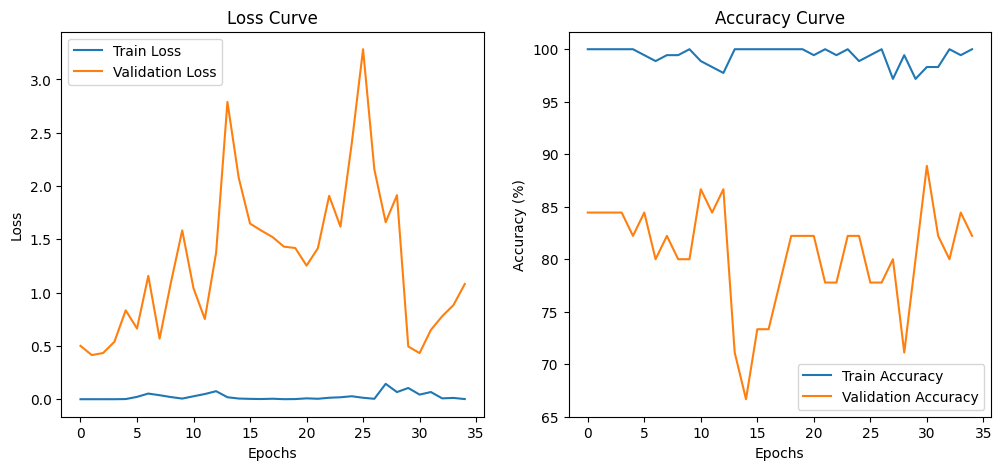

In [ ]:
# Training loop
num_epochs = 35
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


for epoch in range(num_epochs):
    train_loss, train_accuracy = train(resnet152_model, train_loader, criterion, optimizer)
    val_accuracy, val_loss = validate(resnet152_model, val_loader, criterion)

    # Store loss and accuracy values
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting loss curve
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [ ]:
def test(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    test_loss = 0.0
    start_time = time.time()

    with torch.no_grad():  # Disable gradient calculation
        for batch_inputs, batch_labels in test_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, batch_labels)  # Calculate loss
            test_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Compute total elapsed time
    elapsed_time = time.time() - start_time
    # Average test loss
    test_loss /= len(test_loader)

    return all_preds, all_labels, test_loss, elapsed_time


Test Accuracy: 90.32%
Test Loss: 0.8606
Test Time Elapsed: 0.38 seconds
Precision: 92.03%
Recall: 90.32%
F1-Score: 90.32%


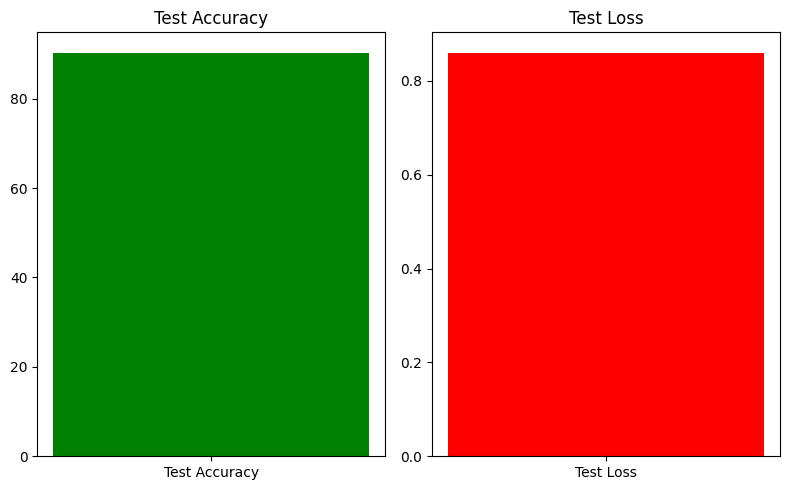

In [ ]:
# Run the test phase
all_preds, all_labels, test_loss, elapsed_time = test(resnet152_model, test_loader, criterion)

# Calculate test accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Time Elapsed: {elapsed_time:.2f} seconds")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(8, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(["Test Accuracy"], [accuracy * 100], color='green')
plt.title('Test Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.bar(["Test Loss"], [test_loss], color='red')
plt.title('Test Loss')

plt.tight_layout()
plt.show()


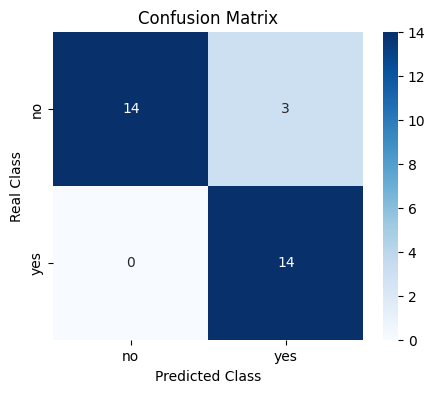

In [ ]:
mt_confusion= confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(mt_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()

**Resnet101**

In [ ]:
resnet101_model = models.resnet101(pretrained=True)
resnet101_model.fc = nn.Linear(resnet101_model.fc.in_features, num_classes)
resnet101_model =resnet101_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 35
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(resnet101_model, train_loader, criterion, optimizer)
    val_accuracy, val_loss = validate(resnet101_model, val_loader, criterion)

    # Store loss and accuracy values
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting loss curve
plt.figure(figsize=(12, 5))


Epoch [1/35], Train Loss: 0.6872, Train Accuracy: 56.50%, Validation Loss: 0.6802, Validation Accuracy: 62.22%
Epoch [2/35], Train Loss: 0.6828, Train Accuracy: 58.19%, Validation Loss: 0.6603, Validation Accuracy: 64.44%
Epoch [3/35], Train Loss: 0.6805, Train Accuracy: 56.50%, Validation Loss: 0.6691, Validation Accuracy: 64.44%
Epoch [4/35], Train Loss: 0.6888, Train Accuracy: 58.19%, Validation Loss: 0.6839, Validation Accuracy: 64.44%
Epoch [5/35], Train Loss: 0.6808, Train Accuracy: 58.19%, Validation Loss: 0.6716, Validation Accuracy: 64.44%
Epoch [6/35], Train Loss: 0.6740, Train Accuracy: 58.76%, Validation Loss: 0.6661, Validation Accuracy: 71.11%
Epoch [7/35], Train Loss: 0.6840, Train Accuracy: 57.06%, Validation Loss: 0.6737, Validation Accuracy: 64.44%
Epoch [8/35], Train Loss: 0.6820, Train Accuracy: 56.50%, Validation Loss: 0.6790, Validation Accuracy: 64.44%
Epoch [9/35], Train Loss: 0.6826, Train Accuracy: 54.24%, Validation Loss: 0.6718, Validation Accuracy: 68.89%
E

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

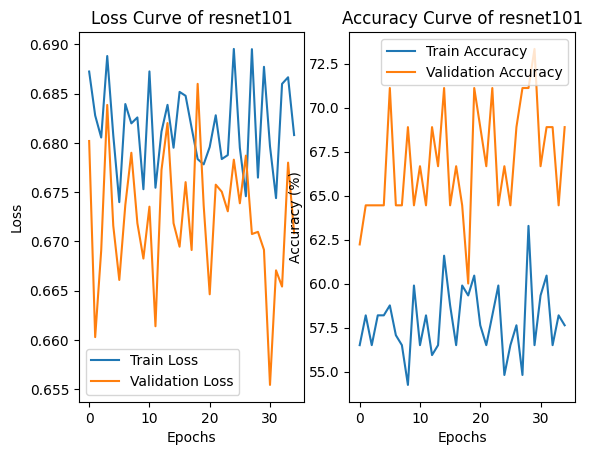

In [ ]:
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve of resnet101')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve of resnet101')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Test Accuracy using resnet101: 54.84%
Test Loss using resnet101: 0.7100
Test Time Elapsed using resnet101: 0.38 seconds
Precision: 59.14%
Recall: 54.84%
F1-Score: 52.91%


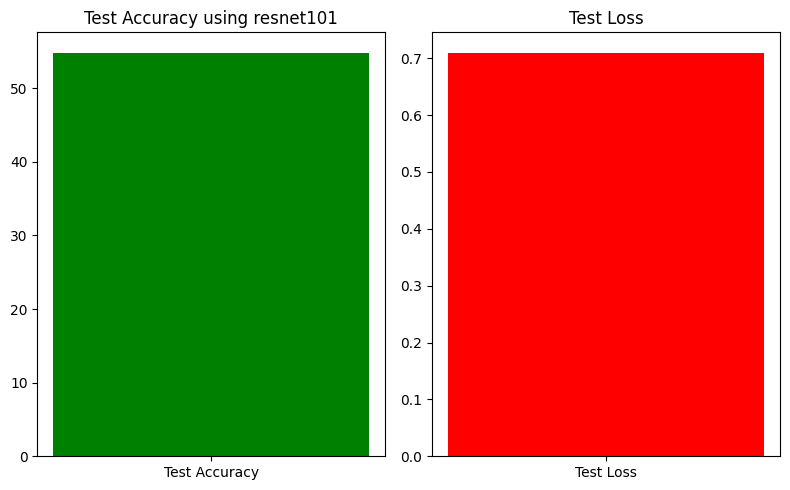

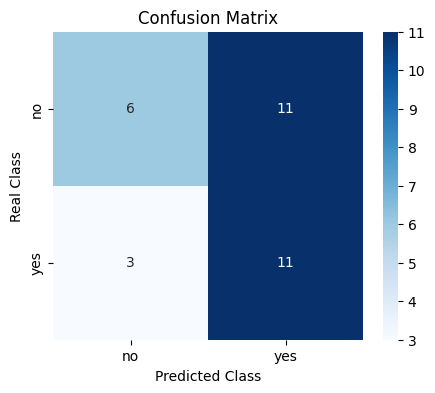

In [ ]:
# Run the test phase
all_preds, all_labels, test_loss, elapsed_time = test(resnet101_model, test_loader, criterion)

# Calculate test accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy using resnet101: {accuracy * 100:.2f}%")
print(f"Test Loss using resnet101: {test_loss:.4f}")
print(f"Test Time Elapsed using resnet101: {elapsed_time:.2f} seconds")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(8, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(["Test Accuracy"], [accuracy * 100], color='green')
plt.title('Test Accuracy using resnet101')

# Loss
plt.subplot(1, 2, 2)
plt.bar(["Test Loss"], [test_loss], color='red')
plt.title('Test Loss')

plt.tight_layout()
plt.show()


mt_confusion= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(mt_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()

**Resnet50**

In [ ]:
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)
resnet50_model =resnet50_model.to(device)

In [ ]:
num_epochs = 35
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(resnet50_model, train_loader, criterion, optimizer)
    val_accuracy, val_loss = validate(resnet50_model, val_loader, criterion)

    # Store loss and accuracy values
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/35], Train Loss: 0.6828, Train Accuracy: 58.19%, Validation Loss: 0.6942, Validation Accuracy: 53.33%
Epoch [2/35], Train Loss: 0.6841, Train Accuracy: 51.98%, Validation Loss: 0.6935, Validation Accuracy: 44.44%
Epoch [3/35], Train Loss: 0.6785, Train Accuracy: 54.80%, Validation Loss: 0.7057, Validation Accuracy: 48.89%
Epoch [4/35], Train Loss: 0.6764, Train Accuracy: 57.06%, Validation Loss: 0.7139, Validation Accuracy: 44.44%
Epoch [5/35], Train Loss: 0.6809, Train Accuracy: 56.50%, Validation Loss: 0.7086, Validation Accuracy: 44.44%
Epoch [6/35], Train Loss: 0.6769, Train Accuracy: 59.32%, Validation Loss: 0.7186, Validation Accuracy: 37.78%
Epoch [7/35], Train Loss: 0.6811, Train Accuracy: 59.89%, Validation Loss: 0.7165, Validation Accuracy: 46.67%
Epoch [8/35], Train Loss: 0.6859, Train Accuracy: 55.93%, Validation Loss: 0.7172, Validation Accuracy: 46.67%
Epoch [9/35], Train Loss: 0.6798, Train Accuracy: 58.76%, Validation Loss: 0.7211, Validation Accuracy: 53.33%
E

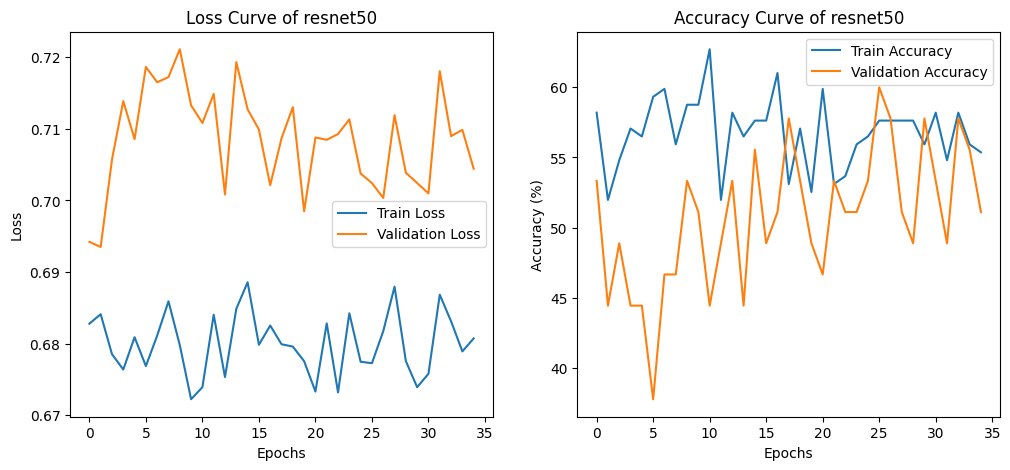

In [ ]:
# Plotting loss curve
plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve of resnet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve of resnet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Test Accuracy using resnet50: 54.84%
Test Loss using resnet50: 0.6631
Test Time Elapsed using resnet50: 0.24 seconds
Precision: 54.84%
Recall: 54.84%
F1-Score: 54.84%


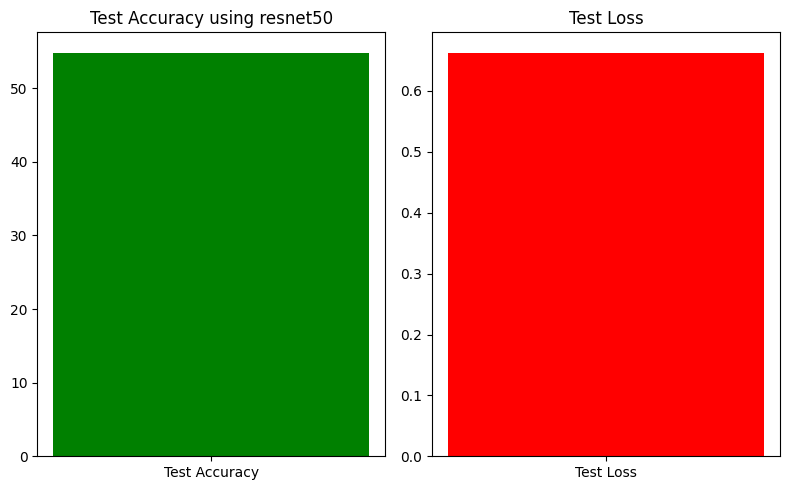

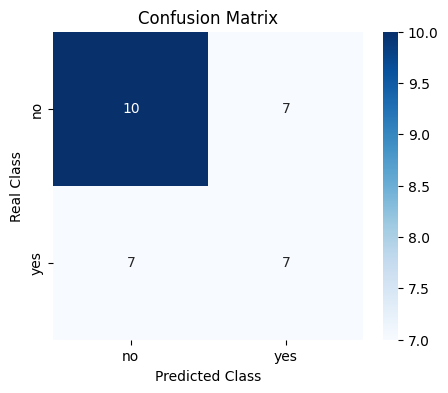

In [ ]:
# Run the test phase
all_preds, all_labels, test_loss, elapsed_time = test(resnet50_model, test_loader, criterion)

# Calculate test accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy using resnet50: {accuracy * 100:.2f}%")
print(f"Test Loss using resnet50: {test_loss:.4f}")
print(f"Test Time Elapsed using resnet50: {elapsed_time:.2f} seconds")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(8, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(["Test Accuracy"], [accuracy * 100], color='green')
plt.title('Test Accuracy using resnet50')

# Loss
plt.subplot(1, 2, 2)
plt.bar(["Test Loss"], [test_loss], color='red')
plt.title('Test Loss')

plt.tight_layout()
plt.show()


mt_confusion= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(mt_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()

**Resnet18**

In [ ]:
resnet18_model = models.resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model =resnet18_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
num_epochs = 35
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(resnet50_model, train_loader, criterion, optimizer)
    val_accuracy, val_loss = validate(resnet50_model, val_loader, criterion)

    # Store loss and accuracy values
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/35], Train Loss: 0.6750, Train Accuracy: 54.80%, Validation Loss: 0.7226, Validation Accuracy: 53.33%
Epoch [2/35], Train Loss: 0.6764, Train Accuracy: 54.80%, Validation Loss: 0.7095, Validation Accuracy: 55.56%
Epoch [3/35], Train Loss: 0.6727, Train Accuracy: 59.32%, Validation Loss: 0.7072, Validation Accuracy: 60.00%
Epoch [4/35], Train Loss: 0.6776, Train Accuracy: 54.80%, Validation Loss: 0.7114, Validation Accuracy: 48.89%
Epoch [5/35], Train Loss: 0.6791, Train Accuracy: 54.24%, Validation Loss: 0.7161, Validation Accuracy: 55.56%
Epoch [6/35], Train Loss: 0.6798, Train Accuracy: 54.24%, Validation Loss: 0.7101, Validation Accuracy: 48.89%
Epoch [7/35], Train Loss: 0.6735, Train Accuracy: 59.89%, Validation Loss: 0.7099, Validation Accuracy: 48.89%
Epoch [8/35], Train Loss: 0.6925, Train Accuracy: 54.80%, Validation Loss: 0.7092, Validation Accuracy: 51.11%
Epoch [9/35], Train Loss: 0.6809, Train Accuracy: 53.11%, Validation Loss: 0.7022, Validation Accuracy: 55.56%
E

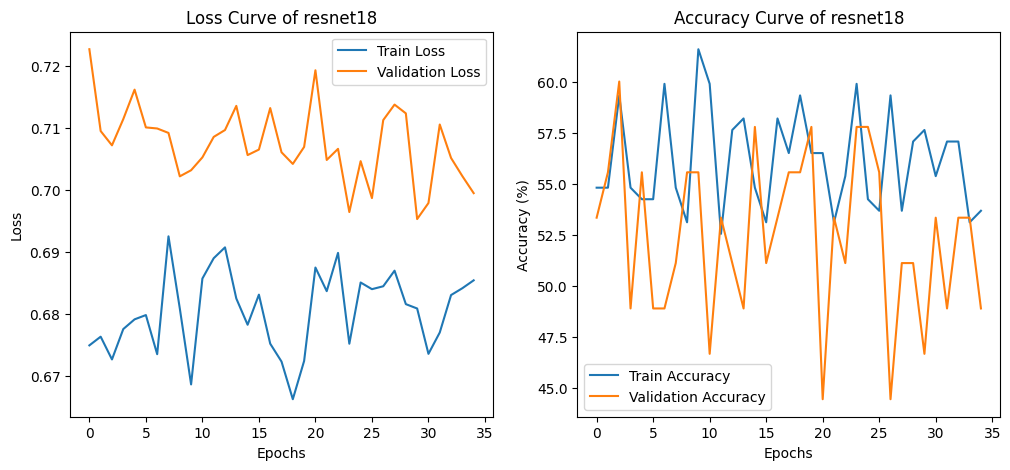

In [ ]:
# Plotting loss curve
plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve of resnet18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve of resnet18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()


Test Accuracy using resnet18: 48.39%
Test Loss using resnet18: 0.6839
Test Time Elapsed using resnet18: 0.19 seconds
Precision: 50.23%
Recall: 48.39%
F1-Score: 47.41%


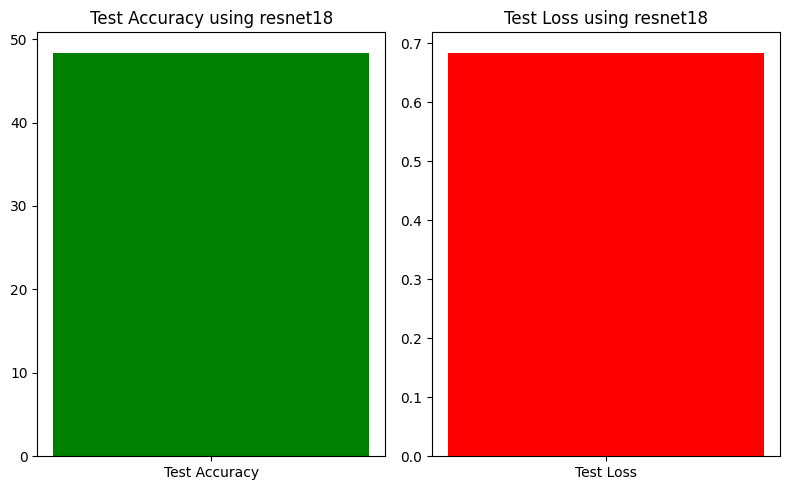

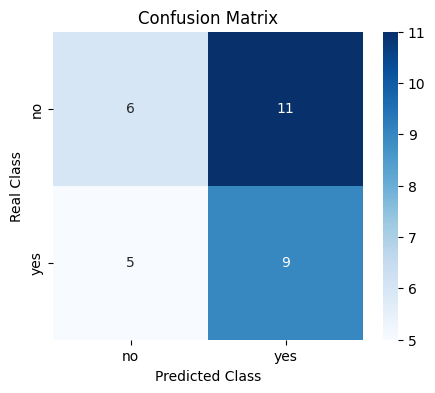

In [ ]:
# Run the test phase
all_preds, all_labels, test_loss, elapsed_time = test(resnet18_model, test_loader, criterion)

# Calculate test accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy using resnet18: {accuracy * 100:.2f}%")
print(f"Test Loss using resnet18: {test_loss:.4f}")
print(f"Test Time Elapsed using resnet18: {elapsed_time:.2f} seconds")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(8, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(["Test Accuracy"], [accuracy * 100], color='green')
plt.title('Test Accuracy using resnet18')

# Loss
plt.subplot(1, 2, 2)
plt.bar(["Test Loss"], [test_loss], color='red')
plt.title('Test Loss using resnet18')

plt.tight_layout()
plt.show()


mt_confusion= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(mt_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()